# Optimization

### Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Dataset Creation
- Generates a simple dataset with two features (X) and binary classification labels (Y).

In [2]:
np.random.seed(0)
X = np.random.rand(2, 100)  # Two features, 100 data points
Y = (X[0, :] + X[1, :] > 1).astype(int)  # Binary classification
Y = Y.reshape(1, -1)

### Initialization of Parameters
- Defines a function initialize_parameters(layers_dims) to initialize the neural network's weights (W) and biases (b) for each layer

In [3]:
def initialize_parameters(layers_dims):
    parameters = {}
    L = len(layers_dims) - 1
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
    return parameters

### Activation Functions
- Implements the sigmoid activation function (sigmoid(z)) which is used to compute the activation values in the neural network

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### Cost Function
- Defines the binary cross-entropy cost function (compute_cost(AL, Y)) to measure the error between the predicted values (AL) and the actual labels (Y).

In [5]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -1/m * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    cost = np.squeeze(cost)
    return cost

### Forward Propagation
- Implements forward propagation (forward_propagation(X, parameters)) to compute the activations (A) for each layer and caches intermediate values (A_prev, W, b, Z) for later use during backpropagation

In [6]:
def forward_propagation(X, parameters):
    A = X
    L = len(parameters) // 2
    caches = []
    for l in range(1, L + 1):
        A_prev = A
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        Z = np.dot(W, A_prev) + b
        A = sigmoid(Z)
        caches.append((A_prev, W, b, Z))
    return A, caches

### Backward Propagation
- Implements backward propagation (backward_propagation(AL, Y, caches)) to compute gradients of the cost with respect to the parameters (dW, db) for each layer

In [7]:
def backward_propagation(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    for l in reversed(range(L)):
        A_prev, W, b, Z = caches[l]
        dZ = dAL * sigmoid(Z) * (1 - sigmoid(Z))
        dW = 1/m * np.dot(dZ, A_prev.T)
        db = 1/m * np.sum(dZ, axis=1, keepdims=True)
        dAL = np.dot(W.T, dZ)
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db
    return grads

### Updata Parameters

In [8]:
def update_parameters(parameters, grads, learning_rate, method="sgd", beta=0.9, epsilon=1e-8):
    L = len(parameters) // 2
    v_dW, v_db = {}, {}

    # Initialize velocity for Adam
    if method == "adam":
        s_dW, s_db = {}, {}

        for l in range(1, L + 1):
            v_dW[f'v_dW{l}'] = np.zeros_like(parameters[f'W{l}'])
            v_db[f'v_db{l}'] = np.zeros_like(parameters[f'b{l}'])
            s_dW[f's_dW{l}'] = np.zeros_like(parameters[f'W{l}'])
            s_db[f's_db{l}'] = np.zeros_like(parameters[f'b{l}'])

    for l in range(1, L + 1):
        if method == "sgd":
            parameters[f'W{l}'] -= learning_rate * grads[f'dW{l}']
            parameters[f'b{l}'] -= learning_rate * grads[f'db{l}']
        elif method == "momentum":
            # Initialize velocity
            if f'v_dW{l}' not in v_dW:
                v_dW[f'{l}'] = np.zeros_like(parameters[f'W{l}'])
                v_db[f'{l}'] = np.zeros_like(parameters[f'b{l}'])
            
            # Update velocity
            v_dW[f'{l}'] = beta * v_dW[f'{l}'] + (1 - beta) * grads[f'dW{l}']
            v_db[f'{l}'] = beta * v_db[f'{l}'] + (1 - beta) * grads[f'db{l}']
            
            # Update parameters
            parameters[f'W{l}'] -= learning_rate * v_dW[f'{l}']
            parameters[f'b{l}'] -= learning_rate * v_db[f'{l}']

        # Fix the update for Adam
        elif method == "adam":
            # Corrected updates for Adam
            v_dW[f'v_dW{l}'] = beta * v_dW[f'v_dW{l}'] + (1 - beta) * grads[f'dW{l}']
            v_db[f'v_db{l}'] = beta * v_db[f'v_db{l}'] + (1 - beta) * grads[f'db{l}']
            s_dW[f's_dW{l}'] = beta * s_dW[f's_dW{l}'] + (1 - beta) * (grads[f'dW{l}'] ** 2)
            s_db[f's_db{l}'] = beta * s_db[f's_db{l}'] + (1 - beta) * (grads[f'db{l}'] ** 2)

            # Corrected moments for Adam
            v_corrected_dW = v_dW[f'v_dW{l}'] / (1 - beta ** 2)
            v_corrected_db = v_db[f'v_db{l}'] / (1 - beta ** 2)
            s_corrected_dW = s_dW[f's_dW{l}'] / (1 - beta ** 2)
            s_corrected_db = s_db[f's_db{l}'] / (1 - beta ** 2)

            # Update parameters for Adam
            parameters[f'W{l}'] -= learning_rate * v_corrected_dW / (np.sqrt(s_corrected_dW) + epsilon)
            parameters[f'b{l}'] -= learning_rate * v_corrected_db / (np.sqrt(s_corrected_db) + epsilon)

    return parameters

### Optimization Methods
- Provides implementations of different optimization methods such as Stochastic Gradient Descent (SGD), Momentum, RMSProp, and Adam for updating the parameters

In [9]:
# Implementation of different optimizers: SGD, Momentum, RMSProp, Adam
def update_parameters_with_sgd(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]
    return parameters

def initialize_velocity(parameters):
    L = len(parameters) // 2
    v = {}

    for l in range(L):
        v["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l+1)])
        v["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l+1)])

    return v

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    L = len(parameters) // 2

    for l in range(L):
        v["dW" + str(l+1)] = beta * v["dW" + str(l+1)] + (1 - beta) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta * v["db" + str(l+1)] + (1 - beta) * grads["db" + str(l+1)]

        parameters["W" + str(l+1)] -= learning_rate * v["dW" + str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * v["db" + str(l+1)]

    return parameters, v

def initialize_rmsprop(parameters):
    L = len(parameters) // 2
    s = {}

    for l in range(L):
        s["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l+1)])
        s["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l+1)])

    return s

def update_parameters_with_rmsprop(parameters, grads, s, beta, learning_rate, epsilon):
    L = len(parameters) // 2

    for l in range(L):
        s["dW" + str(l+1)] = beta * s["dW" + str(l+1)] + (1 - beta) * np.square(grads["dW" + str(l+1)])
        s["db" + str(l+1)] = beta * s["db" + str(l+1)] + (1 - beta) * np.square(grads["db" + str(l+1)])

        parameters["W" + str(l+1)] -= learning_rate * grads["dW" + str(l+1)] / (np.sqrt(s["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)] / (np.sqrt(s["db" + str(l+1)]) + epsilon)

    return parameters, s

def initialize_adam(parameters):
    L = len(parameters) // 2
    v = {}
    s = {}

    for l in range(L):
        v["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l+1)])
        v["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l+1)])
        s["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l+1)])
        s["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l+1)])

    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon):
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}

    for l in range(L):
        v["dW" + str(l+1)]

### Random Minibatching
- Defines a function (random_mini_batches(X, Y, mini_batch_size)) to create random mini-batches from the dataset. This helps in training the model with mini-batch gradient descent

In [10]:
def random_mini_batches(X, Y, mini_batch_size=64):
    m = X.shape[1]
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    num_complete_minibatches = m // mini_batch_size
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

### Learning Rate Decay
- Implements learning rate decay (update_learning_rate(learning_rate, decay_rate, epoch_num)) to gradually reduce the learning rate during training

In [11]:
def update_learning_rate(learning_rate, decay_rate, epoch_num):
    return learning_rate / (1 + decay_rate * epoch_num)

### Model Training
- Defines a function (model(X, Y, layers_dims, optimizer, learning_rate, num_epochs, mini_batch_size)) for training the deep neural network.
- Iterates through epochs and mini-batches, performs forward and backward propagation, updates parameters using the specified optimizer, and records the cost.
- The model is trained with specified hyperparameters such as the optimizer, learning rate, number of epochs, and mini-batch size

In [12]:
def model(X, Y, layers_dims, optimizer='sgd', learning_rate=0.0075, num_epochs=3000, mini_batch_size=64):
    parameters = initialize_parameters(layers_dims)
    costs = []

    for i in range(num_epochs):
        minibatches = random_mini_batches(X, Y, mini_batch_size)
        cost_total = 0

        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            AL, caches = forward_propagation(minibatch_X, parameters)
            cost_total += compute_cost(AL, minibatch_Y)
            grads = backward_propagation(AL, minibatch_Y, caches)
            
            # Update parameters with the chosen optimizer
            parameters = update_parameters(parameters, grads, learning_rate, optimizer)

        cost_avg = cost_total / len(minibatches)
        learning_rate = update_learning_rate(learning_rate, decay_rate=0.01, epoch_num=i)
        costs.append(cost_avg)

        if i % 100 == 0:
            print("Cost after epoch %i: %f" %(i, cost_avg))

    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

### Model Training

Cost after epoch 0: 0.692037
Cost after epoch 100: 0.687122
Cost after epoch 200: 0.681409
Cost after epoch 300: 0.688519
Cost after epoch 400: 0.682840
Cost after epoch 500: 0.685763
Cost after epoch 600: 0.679914
Cost after epoch 700: 0.685656
Cost after epoch 800: 0.685786
Cost after epoch 900: 0.681385
Cost after epoch 1000: 0.682878
Cost after epoch 1100: 0.687188
Cost after epoch 1200: 0.682824
Cost after epoch 1300: 0.688687
Cost after epoch 1400: 0.682779
Cost after epoch 1500: 0.682783
Cost after epoch 1600: 0.684221
Cost after epoch 1700: 0.682804
Cost after epoch 1800: 0.679927
Cost after epoch 1900: 0.684229
Cost after epoch 2000: 0.677047
Cost after epoch 2100: 0.691460
Cost after epoch 2200: 0.687125
Cost after epoch 2300: 0.685786
Cost after epoch 2400: 0.688604
Cost after epoch 2500: 0.688560
Cost after epoch 2600: 0.687165
Cost after epoch 2700: 0.685713
Cost after epoch 2800: 0.684266
Cost after epoch 2900: 0.685785


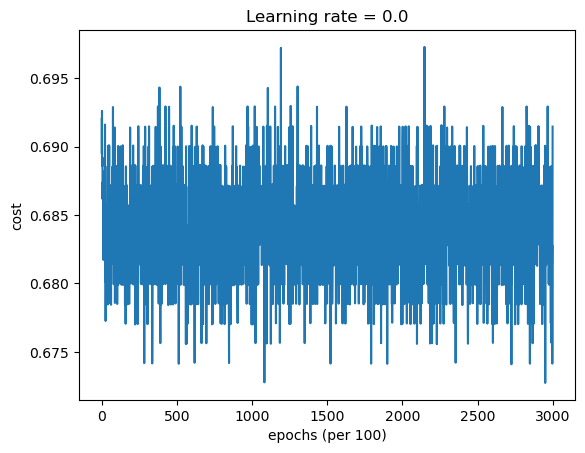

In [13]:
layers_dims = [X.shape[0], 5, 1]
parameters = model(X, Y, layers_dims, optimizer='adam', learning_rate=0.0075, num_epochs=3000)

Training with sgd optimizer...
Cost after epoch 0: 0.692436
Cost after epoch 100: 0.691382
Cost after epoch 200: 0.691124
Cost after epoch 300: 0.690607
Cost after epoch 400: 0.690866
Cost after epoch 500: 0.691124
Cost after epoch 600: 0.690607
Cost after epoch 700: 0.691124
Cost after epoch 800: 0.690607
Cost after epoch 900: 0.690349
Cost after epoch 1000: 0.691382
Cost after epoch 1100: 0.692157
Cost after epoch 1200: 0.691124
Cost after epoch 1300: 0.690349
Cost after epoch 1400: 0.691124
Cost after epoch 1500: 0.690349
Cost after epoch 1600: 0.690607
Cost after epoch 1700: 0.689832
Cost after epoch 1800: 0.691382
Cost after epoch 1900: 0.690091
Cost after epoch 2000: 0.691899
Cost after epoch 2100: 0.691382
Cost after epoch 2200: 0.690607
Cost after epoch 2300: 0.691382
Cost after epoch 2400: 0.691899
Cost after epoch 2500: 0.690866
Cost after epoch 2600: 0.690349
Cost after epoch 2700: 0.690607
Cost after epoch 2800: 0.691124
Cost after epoch 2900: 0.691124


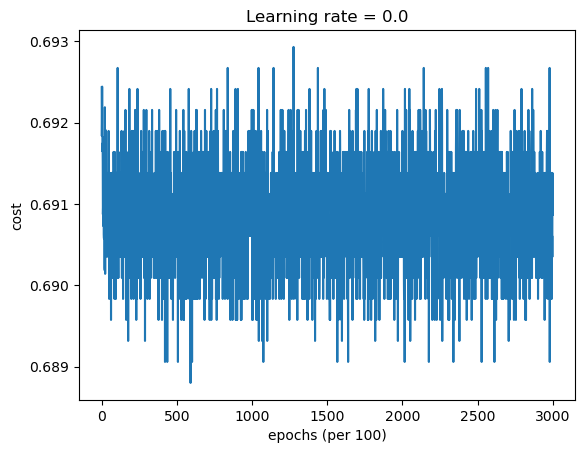

Accuracy with sgd optimizer: 56.00%
Training with momentum optimizer...
Cost after epoch 0: 0.693776
Cost after epoch 100: 0.693501
Cost after epoch 200: 0.693578
Cost after epoch 300: 0.693463
Cost after epoch 400: 0.693500
Cost after epoch 500: 0.693501
Cost after epoch 600: 0.693502
Cost after epoch 700: 0.693463
Cost after epoch 800: 0.693385
Cost after epoch 900: 0.693539
Cost after epoch 1000: 0.693462
Cost after epoch 1100: 0.693576
Cost after epoch 1200: 0.693578
Cost after epoch 1300: 0.693577
Cost after epoch 1400: 0.693577
Cost after epoch 1500: 0.693616
Cost after epoch 1600: 0.693577
Cost after epoch 1700: 0.693616
Cost after epoch 1800: 0.693540
Cost after epoch 1900: 0.693502
Cost after epoch 2000: 0.693424
Cost after epoch 2100: 0.693502
Cost after epoch 2200: 0.693578
Cost after epoch 2300: 0.693731
Cost after epoch 2400: 0.693617
Cost after epoch 2500: 0.693501
Cost after epoch 2600: 0.693539
Cost after epoch 2700: 0.693655
Cost after epoch 2800: 0.693539
Cost after e

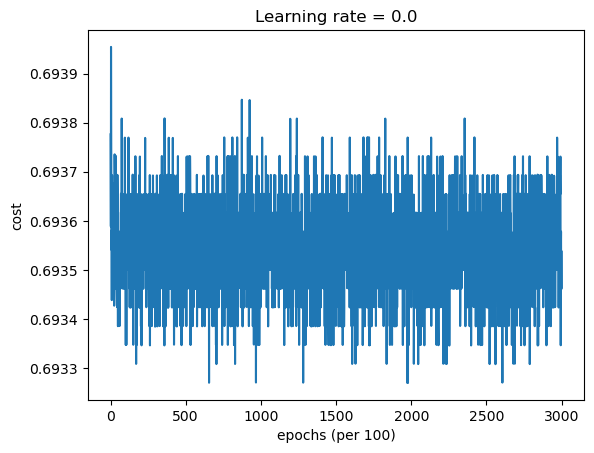

Accuracy with momentum optimizer: 44.00%
Training with rmsprop optimizer...
Cost after epoch 0: 0.694580
Cost after epoch 100: 0.695359
Cost after epoch 200: 0.694735
Cost after epoch 300: 0.694580
Cost after epoch 400: 0.695203
Cost after epoch 500: 0.694580
Cost after epoch 600: 0.693957
Cost after epoch 700: 0.694424
Cost after epoch 800: 0.693956
Cost after epoch 900: 0.695047
Cost after epoch 1000: 0.695203
Cost after epoch 1100: 0.694424
Cost after epoch 1200: 0.695047
Cost after epoch 1300: 0.694424
Cost after epoch 1400: 0.694891
Cost after epoch 1500: 0.694891
Cost after epoch 1600: 0.694891
Cost after epoch 1700: 0.694580
Cost after epoch 1800: 0.694424
Cost after epoch 1900: 0.694112
Cost after epoch 2000: 0.694891
Cost after epoch 2100: 0.695047
Cost after epoch 2200: 0.694268
Cost after epoch 2300: 0.695047
Cost after epoch 2400: 0.694736
Cost after epoch 2500: 0.694268
Cost after epoch 2600: 0.694268
Cost after epoch 2700: 0.695047
Cost after epoch 2800: 0.694424
Cost aft

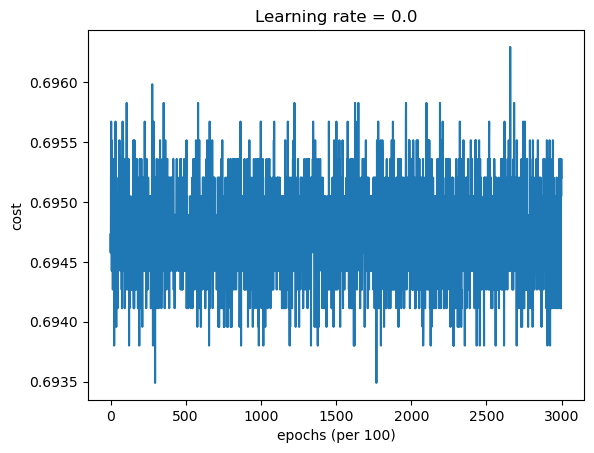

Accuracy with rmsprop optimizer: 44.00%
Training with adam optimizer...
Cost after epoch 0: 0.692575
Cost after epoch 100: 0.676588
Cost after epoch 200: 0.685774
Cost after epoch 300: 0.687263
Cost after epoch 400: 0.682678
Cost after epoch 500: 0.678043
Cost after epoch 600: 0.681114
Cost after epoch 700: 0.684209
Cost after epoch 800: 0.685758
Cost after epoch 900: 0.682620
Cost after epoch 1000: 0.682698
Cost after epoch 1100: 0.682658
Cost after epoch 1200: 0.684195
Cost after epoch 1300: 0.681207
Cost after epoch 1400: 0.682685
Cost after epoch 1500: 0.684212
Cost after epoch 1600: 0.684221
Cost after epoch 1700: 0.687330
Cost after epoch 1800: 0.687229
Cost after epoch 1900: 0.678000
Cost after epoch 2000: 0.684181
Cost after epoch 2100: 0.684236
Cost after epoch 2200: 0.681119
Cost after epoch 2300: 0.682669
Cost after epoch 2400: 0.682632
Cost after epoch 2500: 0.688874
Cost after epoch 2600: 0.682680
Cost after epoch 2700: 0.685778
Cost after epoch 2800: 0.687245
Cost after e

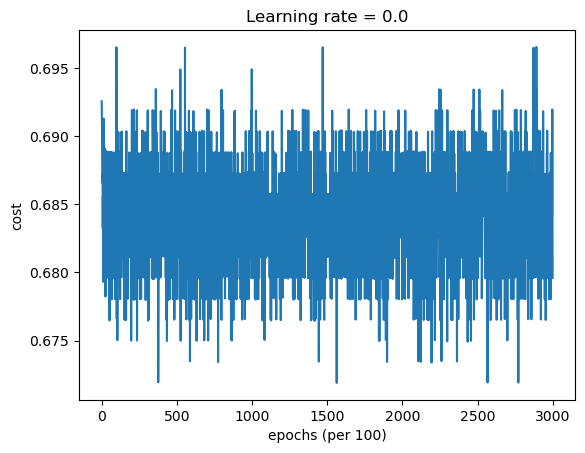

Accuracy with adam optimizer: 56.00%


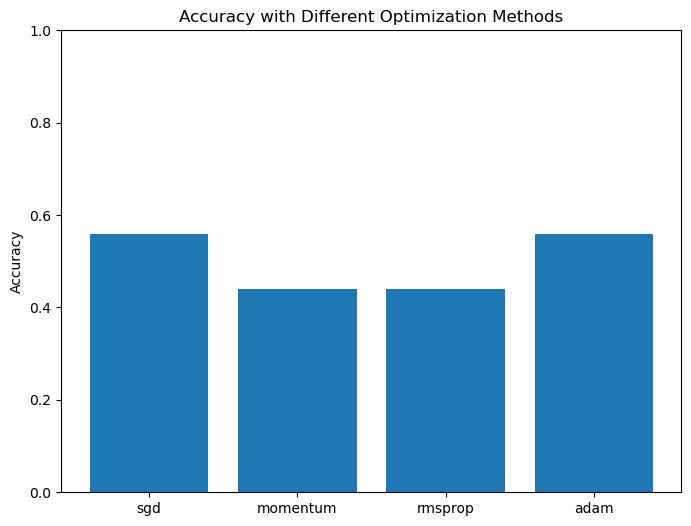

In [14]:
# 12. Model Evaluation
def predict(parameters, X):
    """
    Predicts binary labels for the given input data X.

    Arguments:
    parameters -- parameters learned by the model (output of model function)
    X -- input data of shape (input_size, number of examples)

    Returns:
    predictions -- binary predictions (0/1) for each example in X
    """
    A, _ = forward_propagation(X, parameters)
    predictions = (A > 0.5).astype(int)
    return predictions

def evaluate_model(parameters, X, Y):
    """
    Evaluates the model's performance using accuracy as a metric.

    Arguments:
    parameters -- parameters learned by the model (output of model function)
    X -- input data of shape (input_size, number of examples)
    Y -- true labels of shape (1, number of examples)

    Returns:
    accuracy -- accuracy of the model on the given data
    """
    m = X.shape[1]
    predictions = predict(parameters, X)
    accuracy = np.sum(predictions == Y) / m
    return accuracy

# 13. Testing Different Optimization Methods
optimizers = ["sgd", "momentum", "rmsprop", "adam"]
results = {}

for optimizer in optimizers:
    print(f"Training with {optimizer} optimizer...")
    parameters = model(X, Y, layers_dims, optimizer=optimizer, learning_rate=0.0075, num_epochs=3000)
    accuracy = evaluate_model(parameters, X, Y)
    results[optimizer] = accuracy
    print(f"Accuracy with {optimizer} optimizer: {accuracy:.2%}")

# Plotting the results
plt.figure(figsize=(8, 6))
plt.bar(results.keys(), results.values())
plt.ylabel('Accuracy')
plt.title('Accuracy with Different Optimization Methods')
plt.ylim(0, 1)
plt.show()


## Model Evaluation with Different Optimization Methods

The bar chart above illustrates the accuracy of a binary classification model when trained using different optimization methods.

## Analysis

From left to right, the bars represent the following optimization methods:

- **SGD (Stochastic Gradient Descent)**: This method updates the parameters using only a single example at a time. It provides a baseline accuracy which is competitive but might be less stable or slower to converge compared to other methods.

- **Momentum**: This method accelerates the gradient descent by considering the past gradients to smooth out the update. It usually helps to speed up convergence and can lead to better accuracy, though in this particular case, it seems to perform slightly worse than SGD.

- **RMSprop**: Stands for Root Mean Square Propagation. It adjusts the learning rate for each parameter, which helps to deal with the oscillating efficiency of gradient descent. It shows a similar accuracy to Momentum in this instance.

- **Adam**: Combines the advantages of Momentum and RMSprop. It tends to be the most efficient optimization algorithm for many scenarios. In this chart, Adam shows the highest accuracy among all compared methods.